In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [2]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: .\cifar10.tgz


### This is one time only

In [3]:
# with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
#     tar.extractall(path='./data')

In [4]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print(classes)


['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
airplane_files = os.listdir(data_dir + '/train/airplane')
print('No. of Training examples for airplanes: ', len(airplane_files))
print(airplane_files[:5])

No. of Training examples for airplanes:  5000
['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


So, we have 5000 images for 1 class like this we have 10 more classes which give us a total of 5000 * 10 = 50000 images

In [6]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [7]:
train_dataset = ImageFolder(data_dir + '/train', transform=ToTensor())

In [8]:
img, label = train_dataset[0]
print(img.shape, label)


torch.Size([3, 32, 32]) 0


In [9]:
print(train_dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


We have first 5000 images belong to airplane and the other images belong to automobile and so 

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline



In [11]:
def show(img, label):
    print("Label: ", train_dataset.classes[label], "(" + str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  dog (5)


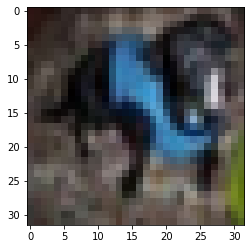

In [12]:
show(*train_dataset[25000])

In [13]:
torch.manual_seed(42);

In [14]:
val_size = 10000
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(40000, 10000)

Label:  horse (7)


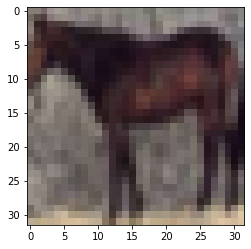

In [15]:
show(*train_ds[0])

In [16]:
from torch.utils.data.dataloader import DataLoader
batch_size = 128

In [17]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [18]:
from torchvision.utils import make_grid

In [19]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]);ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

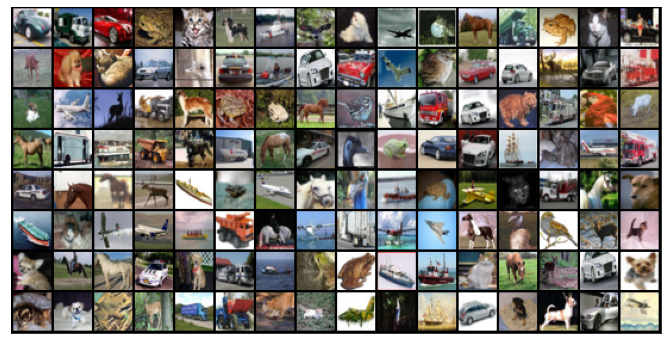

In [20]:
show_batch(train_dl)

In [21]:
def apply_kernel(image, kernel):
    ri, ci = image.shape
    rk, ck = kernel.shape
    ro, co = ri-rk+1, ci-ck+1
    output = torch.zeros([ro, co])
    for i in range(ro):
        for j in range(co):
            output[i, j] = torch.sum(image[i:i+rk, j:j+ck] * kernel)
    return output

In [22]:
sample_image = torch.tensor([
    [3, 3, 2, 1, 0], 
    [0, 0, 1, 3, 1], 
    [3, 1, 2, 2, 3], 
    [2, 0, 0, 2, 2], 
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2], 
    [2, 2, 0], 
    [0, 1, 2]
], dtype=torch.float32)

apply_kernel(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

In [23]:
import torch.nn as nn
import torch.nn.functional as F

In [24]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride = 1, padding=1),
    nn.MaxPool2d(2, 2)
)

In [25]:
for images, labels in train_dl:
    print('image.shape', images.shape)
    out = simple_model(images)
    print('out.shape', out.shape)
    break

image.shape torch.Size([128, 3, 32, 32])
out.shape torch.Size([128, 8, 16, 16])


In [26]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
            
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [27]:
class Cifar10CNNModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [28]:
model = Cifar10CNNModel()
model

Cifar10CNNModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024, out_features

In [29]:
for images, labels in train_dl:
    print('image.shape', images.shape)
    out = model(images)
    print('out.shape', out.shape)
    print('out[0]', out[0])
    break

image.shape torch.Size([128, 3, 32, 32])
out.shape torch.Size([128, 10])
out[0] tensor([-0.0279,  0.0073, -0.0334,  0.0442,  0.0110, -0.0006,  0.0287,  0.0066,
         0.0227,  0.0019], grad_fn=<SelectBackward>)


In [30]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [31]:
device = get_default_device()
device

device(type='cuda')

In [32]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

# Training the Model

In [33]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [34]:
model = to_device(Cifar10CNNModel(), device)

In [35]:
evaluate(model, val_dl)

{'val_loss': 2.3027091026306152, 'val_acc': 0.09853515774011612}

In [36]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 1e-3

In [37]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)
%time

Epoch [0], train_loss: 1.8044, val_loss: 1.5255, val_acc: 0.4335
Epoch [1], train_loss: 1.3086, val_loss: 1.1720, val_acc: 0.5707
Epoch [2], train_loss: 1.0469, val_loss: 1.0176, val_acc: 0.6377
Epoch [3], train_loss: 0.8848, val_loss: 0.8996, val_acc: 0.6877
Epoch [4], train_loss: 0.7567, val_loss: 0.8136, val_acc: 0.7165
Epoch [5], train_loss: 0.6520, val_loss: 0.8195, val_acc: 0.7210
Epoch [6], train_loss: 0.5526, val_loss: 0.7525, val_acc: 0.7457
Epoch [7], train_loss: 0.4544, val_loss: 0.7701, val_acc: 0.7458
Epoch [8], train_loss: 0.3663, val_loss: 0.7971, val_acc: 0.7498
Epoch [9], train_loss: 0.2982, val_loss: 0.8481, val_acc: 0.7555
Wall time: 0 ns


In [38]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [39]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

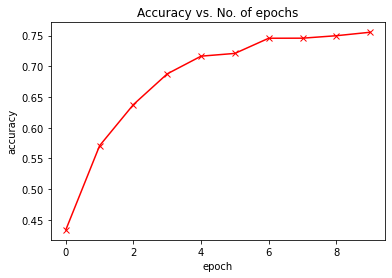

In [40]:
plot_accuracies(history)

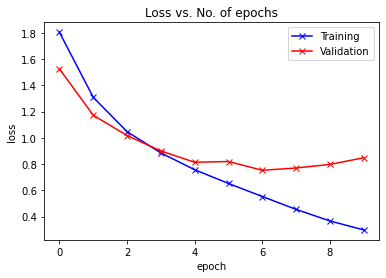

In [41]:
plot_losses(history)

### If We train more we will overfit the model

In [43]:
# Jovian Commit

In [44]:
import jovian

In [45]:
jovian.commit(project = "CIFAR_Classification_PyTorch_CNN_GPU")

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Creating a new project "hemanthhari2000/CIFAR_Classification_PyTorch_CNN_GPU"
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/hemanthhari2000/cifar-classification-pytorch-cnn-gpu


'https://jovian.ai/hemanthhari2000/cifar-classification-pytorch-cnn-gpu'

# Save the model

In [46]:
model_path = 'model/cifar-cnn-gpu.pth'
torch.save(model.state_dict(), model_path)

# Load the model

In [47]:
model2 = to_device(Cifar10CNNModel(), device)

In [49]:
# model2

In [50]:
model2.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [51]:
model2.state_dict()

OrderedDict([('network.0.weight',
              tensor([[[[ 1.4228e-01,  9.4325e-02, -1.5275e-01],
                        [ 7.4079e-02,  6.8173e-02,  1.1526e-02],
                        [-1.6443e-01,  1.1788e-01, -1.7648e-01]],
              
                       [[-3.0945e-02,  5.5012e-02, -1.9654e-01],
                        [-9.8098e-02,  2.0660e-01,  1.2371e-01],
                        [-9.8739e-02,  1.5081e-01, -1.1136e-02]],
              
                       [[-9.4362e-03,  3.8761e-02, -1.1865e-02],
                        [-2.1466e-01,  2.2736e-01, -1.3503e-01],
                        [ 3.2906e-02,  2.2860e-02,  2.6255e-02]]],
              
              
                      [[[-2.9272e-02, -2.5351e-02, -4.9933e-02],
                        [ 1.9464e-01,  1.4571e-01, -1.9035e-01],
                        [ 5.8528e-02,  1.6011e-01, -1.7383e-01]],
              
                       [[ 9.4525e-02, -9.8436e-02,  6.4211e-02],
                        [ 1.4868e-01,  4.

In [52]:
test_dataset = ImageFolder(data_dir + '/test', transform = ToTensor())

In [56]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_dataset.classes[preds[0].item()]

Label:  airplane 
Predicted:  airplane


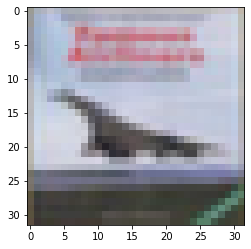

In [58]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label: ', train_dataset.classes[label], '\nPredicted: ', predict_image(img, model2))

Label:  automobile 
Predicted:  automobile


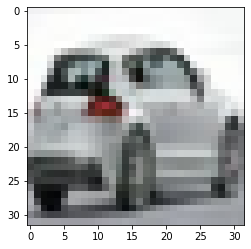

In [59]:
img, label = test_dataset[1010]
plt.imshow(img.permute(1, 2, 0))
print('Label: ', train_dataset.classes[label], '\nPredicted: ', predict_image(img, model2))

In [60]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "hemanthhari2000/cifar-classification-pytorch-cnn-gpu" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/hemanthhari2000/cifar-classification-pytorch-cnn-gpu


'https://jovian.ai/hemanthhari2000/cifar-classification-pytorch-cnn-gpu'